In [1]:
import anndata, pickle, os, fnmatch, math, random
import scipy.stats as stats
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MultipleLocator, LogLocator, LogFormatter, LogFormatterSciNotation, MaxNLocator
import matplotlib.patches as mpatches

In [2]:
# Adding plotting parameters so exported images are compatible with illustrator 
# Code from: https://jonathansoma.com/lede/data-studio/matplotlib/exporting-from-matplotlib-to-open-in-adobe-illustrator/
mlp.rcParams['pdf.fonttype'] = 42
mlp.rcParams['ps.fonttype'] = 42

In [3]:
# Importing necessary functions from general function file
%run GeneralFunctions.ipynb

In [25]:
# Reading in the sample dictionaries
diffExp_withinSample = readDict('F:/FigureCalculations/Figure4/diffExp_WithinSample')
diffExp_bioRep = readDict('F:/FigureCalculations/Figure4/diffExp_BiologicalReplicaSamples')
diffExp_plastCompar = readDict('F:/FigureCalculations/Figure4/diffExp_PlasticityComparisons')
diffExp_hemCompar = readDict('F:/FigureCalculations/Figure4/diffExp_HemiComparisons')

In [26]:
sampleNameLst = [['MD Contra. Hem. (L)', '1_VC20L'], ['MD Ipsi. Hem. (R)', '3_VC20R'], ['Deafened', '5_VC22L'],
                 ['Control', '7_VC24L'], ['Control', '9_VC23L'], ['Deafened', '10_VC25L'], ['MD Contra. Hem. (L)', '16_VC19L'],
                 ['MD Ipsi. Hem. (R)', '17_VC19R'], ['MD Contra. Hem. (L)', '2_AC20L'], ['MD Ipsi. Hem. (R)', '4_AC20R'],
                 ['Deafened', '6_AC22L'], ['Control', '8_AC24L'],   ['Deafened', '13_AC25L'], ['Control', '14_AC23L'],   
                 ['MD Contra. Hem. (L)', '19_AC19L'], ['MD Ipsi. Hem. (R)', '20_AC19R']]
                   
bioRepComparisonLst = [['Control', '7_VC24L', '9_VC23L'], ['Deafened', '5_VC22L', '10_VC25L'], 
                       ['MD Contra. Hem. (L)', '16_VC19L', '1_VC20L'], ['MD Ipsi. Hem. (R)', '17_VC19R', '3_VC20R'],
                       ['Control', '8_AC24L', '14_AC23L'], ['Deafened', '6_AC22L', '13_AC25L'], 
                       ['MD Contra. Hem. (L)', '19_AC19L', '2_AC20L'], ['MD Ipsi. Hem. (R)', '20_AC19R', '4_AC20R']]
                           
plastComparLst = [['Deaf VC vs. Control VC', '5_VC22L', '7_VC24L'], ['Deaf VC vs. Control VC', '5_VC22L', '9_VC23L'], 
                  ['Deaf VC vs. Control VC', '10_VC25L', '7_VC24L'], ['Deaf VC vs. Control VC', '10_VC25L', '9_VC23L'], 
                  ['MD VC vs. Control VC', '16_VC19L', '7_VC24L'], ['MD VC vs. Control VC', '16_VC19L', '9_VC23L'], 
                  ['MD VC vs. Control VC', '1_VC20L', '7_VC24L'], ['MD VC vs. Control VC', '1_VC20L', '9_VC23L'], 
                  ['Deaf AC vs. Control AC', '6_AC22L', '8_AC24L'], ['Deaf AC vs. Control AC', '6_AC22L', '14_AC23L'], 
                  ['Deaf AC vs. Control AC', '13_AC25L', '8_AC24L'], ['Deaf AC vs. Control AC', '13_AC25L', '14_AC23L'], 
                  ['MD AC vs. Control AC', '19_AC19L', '8_AC24L'], ['MD AC vs. Control AC', '19_AC19L', '14_AC23L'], 
                  ['MD AC vs. Control AC', '2_AC20L', '8_AC24L'], ['MD AC vs. Control AC', '2_AC20L', '14_AC23L']]

hemComparLst = [['VC Contra (L) vs. Ipsi Hem (R)', '16_VC19L', '17_VC19R'], 
                ['AC Contra (L) vs. Ipsi Hem (R)', '19_AC19L', '20_AC19R'], 
                ['VC Contra (L) vs. Ipsi Hem (R)', '1_VC20L', '3_VC20R'], 
                ['AC Contra (L) vs. Ipsi Hem (R)', '2_AC20L','4_AC20R']]

In [10]:
def getBoxPlotData(sampleComparLst, diffExpDict, regionOfInterest, conditionOfInterest):
    relevantSampleLsts = []
    relevantSampleCounts = []
    
    for sampleLst in sampleComparLst:
        condition = sampleLst[0]
        sample1_name = sampleLst[1]
        sample2_name = sampleLst[2]
        if (conditionOfInterest == 'Deaf') or (conditionOfInterest == 'MD'): 
            if (regionOfInterest in sample1_name) and (regionOfInterest in condition) and (conditionOfInterest in condition):
                if comaringSex(sample1_name, sample2_name):
                    relevantSampleLsts.append(sampleLst)
                    diffExpCounts = diffExpDict[f'{sample1_name}_{sampleLst[2]}']
                    relevantSampleCounts.append(diffExpCounts)
        elif regionOfInterest == None:
            if conditionOfInterest == 'SameSex':
                if comaringSex(sample1_name, sample2_name):
                    relevantSampleLsts.append(sampleLst)
                    diffExpCounts = diffExpDict[f'{sample1_name}_{sampleLst[2]}']
                    relevantSampleCounts.append(diffExpCounts)
            elif conditionOfInterest == 'DiffSex':
                if not comaringSex(sample1_name, sample2_name):
                    relevantSampleLsts.append(sampleLst)
                    diffExpCounts = diffExpDict[f'{sample1_name}_{sampleLst[2]}']
                    relevantSampleCounts.append(diffExpCounts)
        else: 
            if (regionOfInterest in sample1_name):
                if comaringSex(sample1_name, sample2_name):
                    relevantSampleLsts.append(sampleLst)
                    diffExpCounts = diffExpDict[f'{sample1_name}_{sampleLst[2]}']
                    relevantSampleCounts.append(diffExpCounts)

    return relevantSampleLsts, relevantSampleCounts

def tTestBetweenSamples(data1, data2):
    # Conducting t-test
    t_stat, p_value = stats.ttest_ind(data1, data2)

    # Adding significance asterisks to the plot
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = 'ns'

    return(p_value, significance)

In [46]:
# Getting BoxPlot Data
# AC in Bio Reps. vs. Deaf vs Control Samples in Plasticity Compar. 
box1_samples, box1_diffExpCounts = getBoxPlotData(bioRepComparisonLst, diffExp_bioRep, 'AC', None)
box2_samples, box2_diffExpCounts = getBoxPlotData(plastComparLst, diffExp_plastCompar, 'AC', 'Deaf')
box1_data = [count for lst in box1_diffExpCounts for count in lst]
box2_data = [count for lst in box2_diffExpCounts for count in lst]

# VC in Bio Reps. vs. MD vs Control Samples in Plasticity Compar. 
box3_samples, box3_diffExpCounts = getBoxPlotData(bioRepComparisonLst, diffExp_bioRep, 'VC', None)
box4_samples, box4_diffExpCounts = getBoxPlotData(plastComparLst, diffExp_plastCompar, 'VC', 'MD')
box3_data = [count for lst in box3_diffExpCounts for count in lst]
box4_data = [count for lst in box4_diffExpCounts for count in lst]

In [27]:
# Bio. Rep. Same Sex vs. Diff Sex
box5_samples, box5_diffExpCounts = getBoxPlotData(bioRepComparisonLst, diffExp_bioRep, None, 'SameSex')
box5_data = [count for lst in box5_diffExpCounts for count in lst]

box6_samples, box6_diffExpCounts = getBoxPlotData(bioRepComparisonLst, diffExp_bioRep, None, 'DiffSex')
box6_data = [count for lst in box6_diffExpCounts for count in lst]

# Plast. Compar. Same Sex vs. Diff Sex
box7_samples, box7_diffExpCounts = getBoxPlotData(plastComparLst, diffExp_plastCompar, None, 'SameSex')
box7_data = [count for lst in box7_diffExpCounts for count in lst]

box8_samples, box8_diffExpCounts = getBoxPlotData(plastComparLst, diffExp_plastCompar, None, 'DiffSex')
box8_data = [count for lst in box8_diffExpCounts for count in lst]

# Hemi. Compar. Same Sex vs. Diff Sex
box9_samples, box9_diffExpCounts = getBoxPlotData(hemComparLst, diffExp_hemCompar, None, 'SameSex')
box9_data = [count for lst in box9_diffExpCounts for count in lst]

box10_samples, box10_diffExpCounts = getBoxPlotData(hemComparLst, diffExp_hemCompar, None, 'DiffSex')
box10_data = [count for lst in box10_diffExpCounts for count in lst]

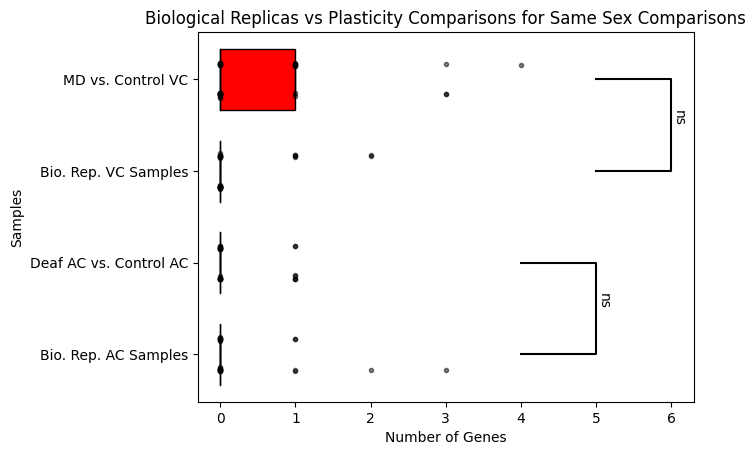

In [65]:
# SIDEWAYS BOX PLOT 
# Creating a figure and axes
fig, ax = plt.subplots()

b1_pos = 2
b2_pos = 5
b3_pos = 8
b4_pos = 11

allBoxData = [box1_diffExpCounts, box2_diffExpCounts, box3_diffExpCounts, box4_diffExpCounts]
allBoxPos = [b1_pos, b2_pos, b3_pos, b4_pos]

# Creating boxplot
# flierprops = dict(marker='o', markersize=3, markerfacecolor='black')
boxplot = ax.boxplot([box1_data, box2_data, box3_data, box4_data], vert=False, patch_artist=True, showfliers=False,
                     medianprops={'color': 'black'}, widths = (2, 2, 2, 2), positions=(b1_pos, b2_pos, b3_pos, b4_pos))

# Customizing the plot
ax.set_yticklabels(['Bio. Rep. AC Samples', 'Deaf AC vs. Control AC', 'Bio. Rep. VC Samples', 'MD vs. Control VC'])
ax.set_ylabel('Samples')  
ax.set_xlabel('Number of Genes')
ax.set_title('Biological Replicas vs Plasticity Comparisons for Same Sex Comparisons')  


# # Plotting individual data points on top of the box plot
for boxDataLst, boxPos in zip(allBoxData, allBoxPos):
    if len(boxDataLst) == 2:
        jitter = 0.5
        pointsLoc = [(boxPos - jitter), (boxPos + jitter)]
    else:
        pointsLoc = [num for num in np.arange((boxPos - 0.5), (boxPos + 0.75), 0.25)]
        pointsLoc.remove(boxPos)
    for data, yLoc in zip(boxDataLst, pointsLoc): 
        
        ax.plot(data, np.random.normal(yLoc,  0.04, len(data)), 'o', color='black', markersize=3, alpha=0.5, 
                zorder=10)

#
colors = ['skyblue', 'blue', 'lightcoral', 'red'] 
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# adding significance for 1st comparison
pValue, significance = tTestBetweenSamples(box1_data, box2_data)
x, h, col = max(box1_data), 2, 'k'
y1 = b1_pos
y2 = b2_pos
plt.plot([x+1, x+h, x+h, x+1], [y1, y1, y2, y2], lw=1.5, c=col)
plt.text(x+h+0.1, (y1+y2)*.5, f'{significance}', ha='center', va='bottom', color=col, rotation=270)

# Adding significance for 2nd comparison
pValue, significance = tTestBetweenSamples(box3_data, box4_data)
x, h, col = max(box4_data), 2, 'k'
y1 = b3_pos
y2 = b4_pos
plt.plot([x+1, x+h, x+h, x+1], [y1, y1, y2, y2], lw=1.5, c=col)
plt.text(x+h+0.1, (y1+y2)*.5, f'{significance}', ha='center', va='bottom', color=col, rotation=270)

plt.show()


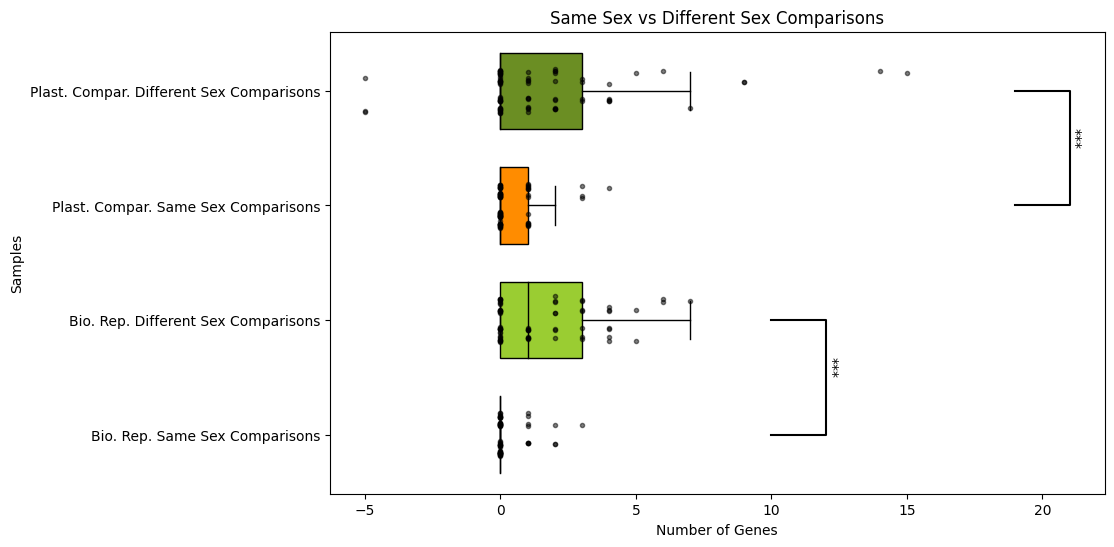

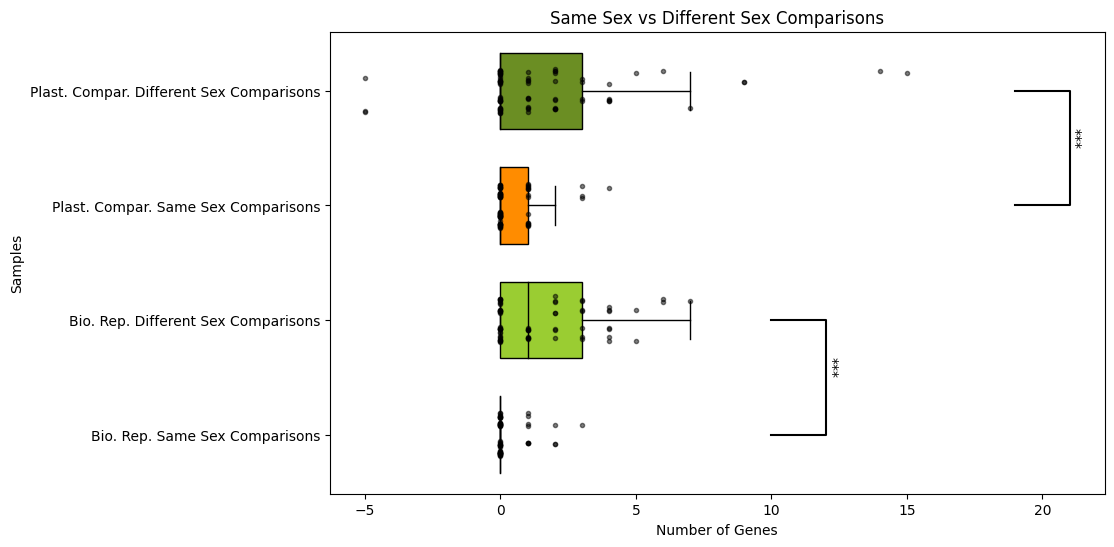

In [68]:
'''SAME SEX VS DIFFERENT SEX COMPARISONS'''

# Creating a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

b5_pos = 2
b6_pos = 5
b7_pos = 8
b8_pos = 11

allBoxData = [box5_diffExpCounts, box6_diffExpCounts, box7_diffExpCounts, box8_diffExpCounts]
allBoxPos = [b5_pos, b6_pos, b7_pos, b8_pos]

# Creating boxplot
# flierprops = dict(marker='o', markersize=3, markerfacecolor='black')
boxplot = ax.boxplot([box5_data, box6_data, box7_data, box8_data], vert=False, patch_artist=True, 
                     showfliers=False, medianprops={'color': 'black'}, widths = (2, 2, 2, 2), 
                     positions=(b5_pos, b6_pos, b7_pos, b8_pos))

# Customizing the plot
ax.set_yticklabels(['Bio. Rep. Same Sex Comparisons', 'Bio. Rep. Different Sex Comparisons',
                    'Plast. Compar. Same Sex Comparisons', 'Plast. Compar. Different Sex Comparisons'])
ax.set_ylabel('Samples')  
ax.set_xlabel('Number of Genes')
ax.set_title('Same Sex vs Different Sex Comparisons')  


# # Plotting individual data points on top of the box plot
for boxDataLst, boxPos in zip(allBoxData, allBoxPos):
    if len(boxDataLst) == 2:
        jitter = 0.5
        pointsLoc = [(boxPos - jitter), (boxPos + jitter)]
    else:
        pointsLoc = [num for num in np.arange((boxPos - 0.5), (boxPos + 0.75), 0.25)]
        pointsLoc.remove(boxPos)
    for data, yLoc in zip(boxDataLst, pointsLoc): 
        
        ax.plot(data, np.random.normal(yLoc,  0.04, len(data)), 'o', color='black', markersize=3, alpha=0.5, 
                zorder=10)

#
colors = ['bisque', 'yellowgreen', 'darkorange', 'olivedrab'] 
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# adding significance for 1st comparison
pValue, significance = tTestBetweenSamples(box5_data, box6_data)
x, h, col = max(box5_data) + 7, 2, 'k'
y1 = b5_pos
y2 = b6_pos
plt.plot([x, x+h, x+h, x], [y1, y1, y2, y2], lw=1.5, c=col)
plt.text(x+h+0.2, (y1+y2)*.5, f'{significance}', ha='center', va='bottom', color=col, rotation=270)

# Adding significance for 2nd comparison
pValue, significance = tTestBetweenSamples(box7_data, box8_data)
x, h, col = max(box7_data) + 2, 2, 'k'
y1 = b7_pos
y2 = b8_pos
plt.plot([x, x+h, x+h, x], [y1, y1, y2, y2], lw=1.5, c=col)
plt.text(x+h+0.2, (y1+y2)*.5, f'{significance}', ha='center', va='bottom', color=col, rotation=270)

plt.show(False)
plt.savefig(os.path.join('F:/Figures/Figure4/', f'SameSex_vs_DiffSex.jpg'), dpi=200, bbox_inches = 'tight', transparent=True)

In [ ]:
# RE-ARRANGE THIS LATER 

In [ ]:
bioRepComparisonLst = [['Control', '7_VC24L', '9_VC23L'], ['Deafened', '5_VC22L', '10_VC25L'], 
                       ['MD Contra. Hem. (L)', '16_VC19L', '1_VC20L'], ['MD Ipsi. Hem. (R)', '17_VC19R', '3_VC20R'],
                       ['Control', '8_AC24L', '14_AC23L'], ['Deafened', '6_AC22L', '13_AC25L'], 
                       ['MD Contra. Hem. (L)', '19_AC19L', '2_AC20L'], ['MD Ipsi. Hem. (R)', '20_AC19R', '4_AC20R']]

In [ ]:
    
def sexComparison(comparisonLst):
    row = 6 
    col = 4

    ax1 = plt.subplot2grid((row, col), (0, 0), colspan=2, rowspan=2) # Clustered UMAP
    
    ax2 = plt.subplot2grid((row, col), (2, 0), colspan=2) 

    ax3 = plt.subplot2grid((row, col), (2, 1), colspan=2) 
    
    ax4 = plt.subplot2grid((row, col), (1, 2), colspan=2)
    
    ax5 = plt.subplot2grid((row, col), (1, 4), colspan=2) 
    